In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
x = np.fromfile('voyager1_sideband.c64', 'complex64')
fs = 2.9296875e6/35/50
x /= np.average(np.abs(x)**2)

In [3]:
def plot_spec(x, N=1024):
    plt.plot(
        np.fft.fftshift(np.fft.fftfreq(N, 1/fs)),
        10*np.log10(
            np.fft.fftshift(np.average(
                np.abs(np.fft.fft(x[:x.size//N*N].reshape((-1, N))))**2,
                axis=0
            ))))

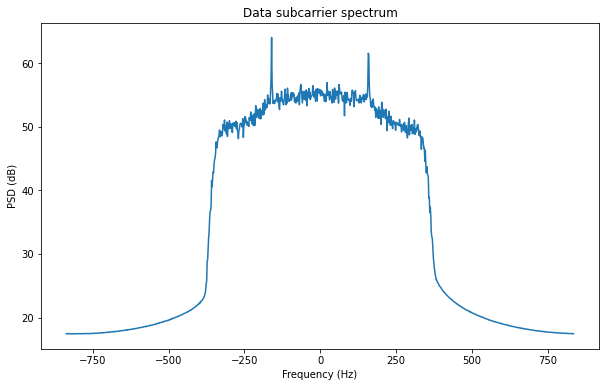

In [4]:
plot_spec(x)
#plt.ylim((12.5,23));
plt.title('Data subcarrier spectrum')
plt.ylabel('PSD (dB)')
plt.xlabel('Frequency (Hz)');

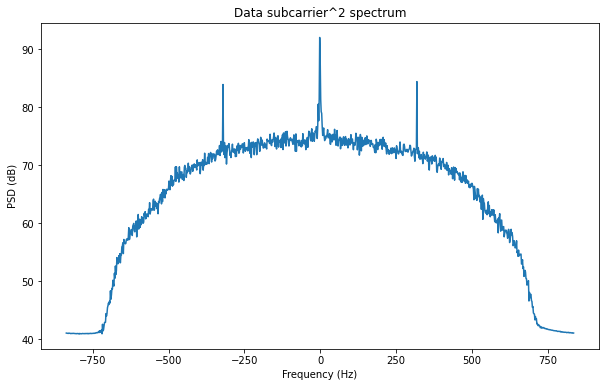

In [5]:
plot_spec(x**2)
plt.title('Data subcarrier^2 spectrum')
plt.ylabel('PSD (dB)')
plt.xlabel('Frequency (Hz)');

In [6]:
f = np.fft.fft(x**2)
keep = 100
f[keep//2:-keep//2+1] = 0
y = np.fft.ifft(f)

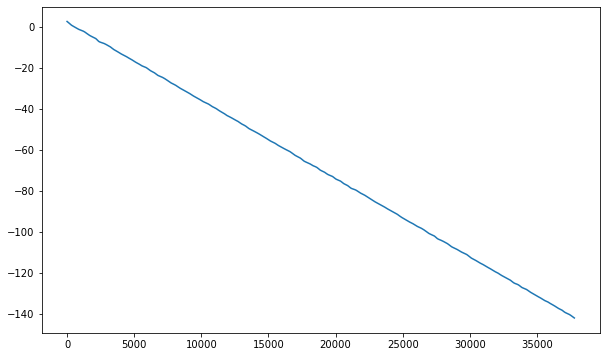

In [7]:
plt.plot(np.unwrap(np.angle(y)))

In [8]:
z = x * np.exp(-1j*np.unwrap(np.angle(y))/2)

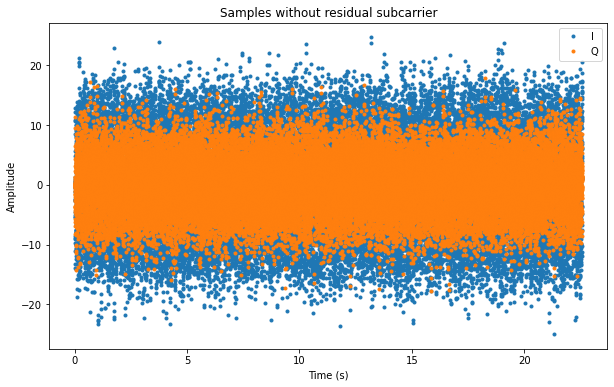

In [9]:
t = np.arange(z.size)/fs
plt.plot(t, z.real[:], '.')
plt.plot(t, z.imag[:], '.')
plt.title('Samples without residual subcarrier')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['I', 'Q']);

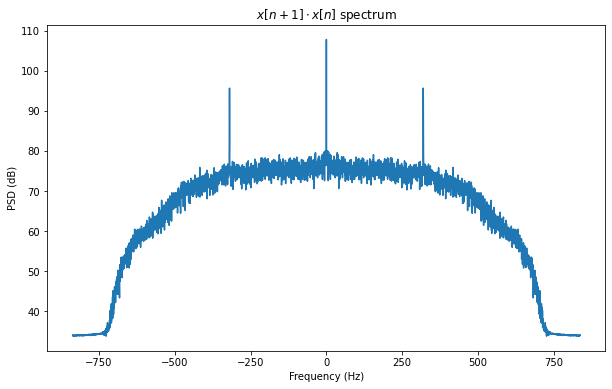

In [10]:
z_diff = z.real[1:] * z.real[:-1]
N = 4096
plt.plot(
    np.fft.fftshift(np.fft.fftfreq(N, 1/fs)),
    10*np.log10(np.fft.fftshift(
        np.average(np.abs(
            np.fft.fft(z_diff[:z_diff.size//N*N].reshape((-1, N))))**2,
            axis=0))))
plt.title('$x[n+1]\cdot x[n]$ spectrum')
plt.ylabel('PSD (dB)')
plt.xlabel('Frequency (Hz)');

In [11]:
baudrate = 320
sps = fs/baudrate

In [12]:
sps

5.231584821428571

In [13]:
zz = np.convolve(z, np.ones(int(sps))/int(sps))

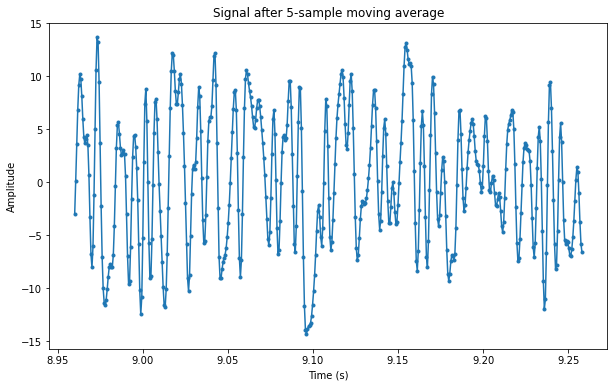

In [14]:
t = np.arange(zz.size)/fs
sel = slice(15000, 15500)
plt.plot(t[sel], zz.real[sel], '.-')
plt.title('Signal after 5-sample moving average')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)');

0.20338203798597662

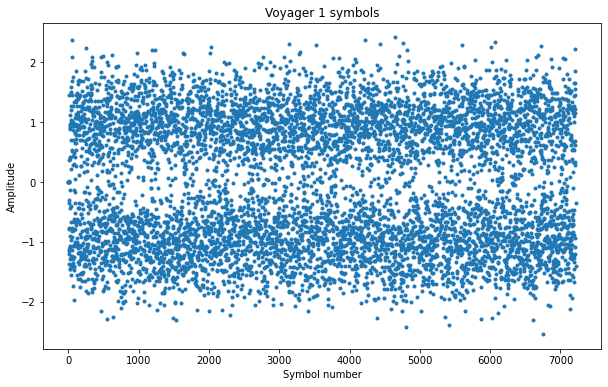

In [15]:
start = 3.3
eps = 1e-3
select = np.arange(start, zz.size-1, sps * (1+eps))
syms = zz[np.int32(np.round(select))]
syms /= np.average(np.abs(syms.real))
plt.plot(syms.real, '.')
plt.title('Voyager 1 symbols')
plt.ylabel('Amplitude')
plt.xlabel('Symbol number')
syms_hd = np.sign(syms.real)
np.average((syms.real - syms_hd)**2)

Text(0, 0.5, 'Imaginary part')

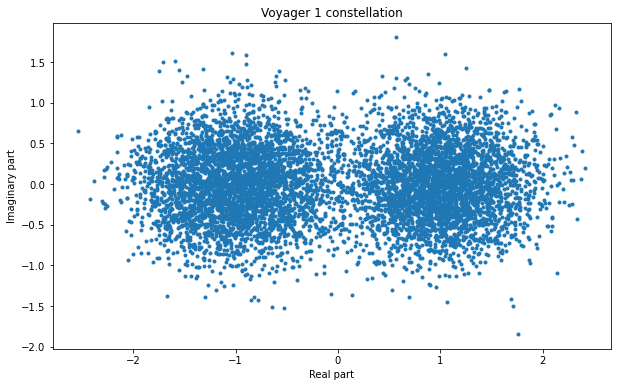

In [16]:
plt.plot(syms.real, syms.imag, '.')
plt.title('Voyager 1 constellation')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')

In [54]:
pair_adjust = 1
syms_concat = np.concatenate((syms, np.zeros(128)))
syms_concat[pair_adjust:].real.astype('float32').tofile('voyager1_symbols.f32')

In [55]:
encoder_out = np.fromfile('convolutional_encoder_out.u8', dtype='uint8')
encoder_out.size, syms.size

(7296, 7216)

In [56]:
bit_errors = encoder_out[:syms.size-pair_adjust] ^ (syms[pair_adjust:].real >= 0)
np.average(bit_errors)

0.016493416493416492

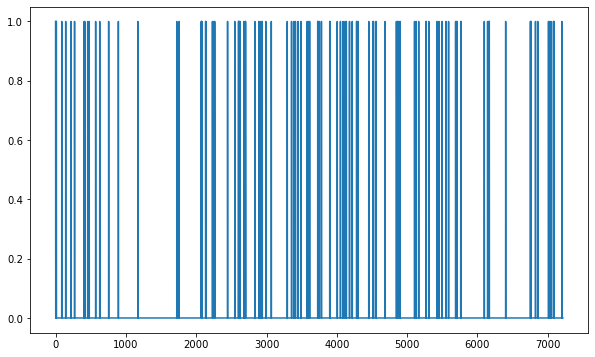

In [57]:
plt.plot(bit_errors);

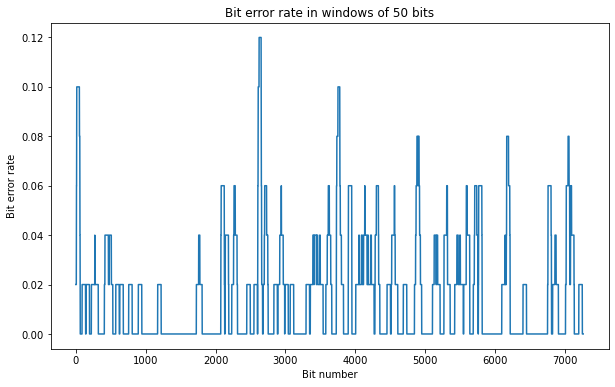

In [58]:
plt.plot(np.convolve(bit_errors, np.ones(50)/50))
plt.title('Bit error rate in windows of 50 bits')
plt.xlabel('Bit number')
plt.ylabel('Bit error rate');

In [59]:
viterbi_out = np.fromfile('viterbi_decoder_out.u8', dtype='uint8')
viterbi_out.size

3648

In [60]:
viterbi_out = viterbi_out[:(syms.size-pair_adjust)//2]
viterbi_out.size

3607

In [61]:
asm = 2*np.unpackbits(np.frombuffer(bytes.fromhex('03915ED3'), 'uint8')).astype('float')-1

In [62]:
asm

array([-1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1., -1., -1.,  1.,  1.])

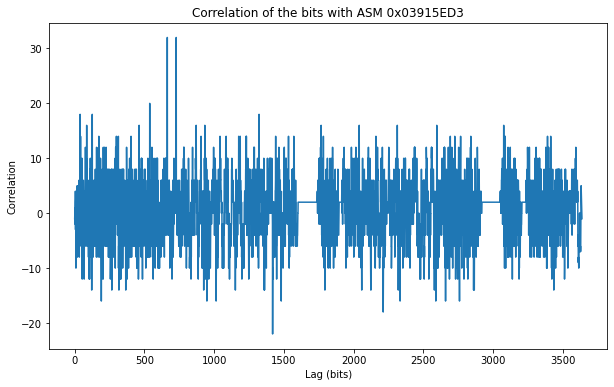

In [63]:
bits = 2*viterbi_out.astype('float')-1
corr_asm = np.correlate(bits, asm, mode='full')
plt.plot(corr_asm)
plt.title('Correlation of the bits with ASM 0x03915ED3')
plt.ylabel('Correlation')
plt.xlabel('Lag (bits)');

In [64]:
np.where(corr_asm == asm.size)

(array([664, 728]),)

In [65]:
asm_start = np.where(corr_asm == asm.size)[0][0] - asm.size + 1
asm_start

633

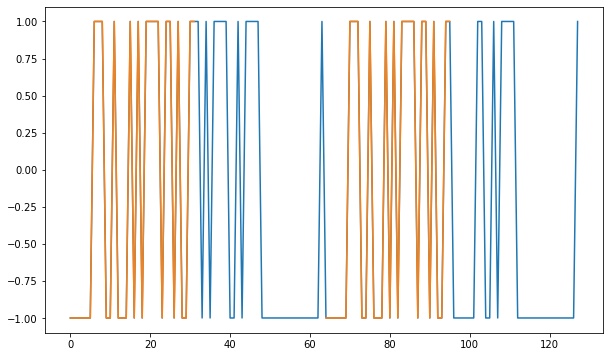

In [66]:
plt.plot(bits[asm_start:][:128])
plt.plot(asm)
plt.plot(np.arange(asm.size)+2*asm.size, asm, color='C1')

In [67]:
asm_start % 64

57

In [68]:
asm_start // 64

9

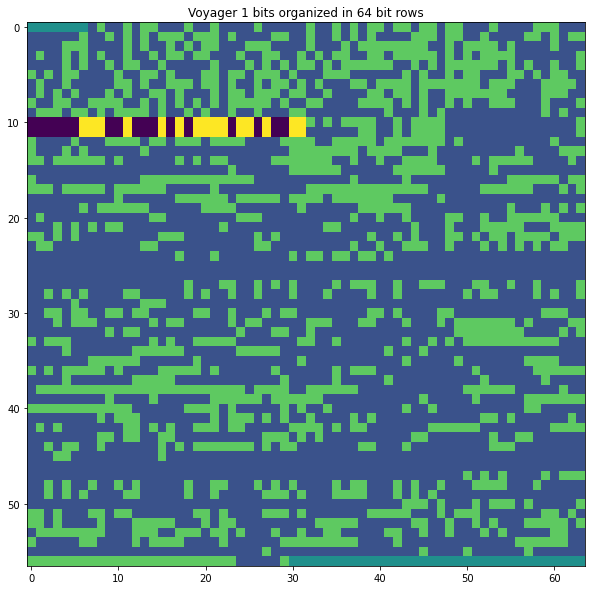

In [69]:
l = 64
bits_asm_mark = bits.copy()
bits_asm_mark[asm_start:asm_start+32] *= 2
bits_asm_mark[asm_start+64:asm_start+96] *= 2
bits_pad = np.concatenate((np.zeros(l - (asm_start % l), 'uint8'),
                           bits_asm_mark))
bits_pad = np.concatenate((bits_pad,
                           np.zeros(l - (bits_pad.size % l), 'uint8')))
plt.figure(figsize=(10,10))
plt.imshow(bits_pad.reshape((-1,l)), aspect='auto', interpolation='none')
plt.title('Voyager 1 bits organized in 64 bit rows');